In [ ]:
!pip install geopandas
!pip install earthpy
!pip install mlxtend

In [ ]:
import datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFE
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import normalize, PowerTransformer, power_transform, scale, StandardScaler
from sklearn.pipeline import make_pipeline
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
import earthpy as et
from tqdm.notebook import tqdm
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.evaluate import PredefinedHoldoutSplit
import json
import copy
import urllib.request
# pd.set_option("display.max_rows", None, "display.max_columns", None)

In [ ]:
# Main source for the training data
DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
# Local file
DATA_FILE = 'data/OxCGRT_latest.csv'
if not os.path.exists('data'):
    os.mkdir('data')
urllib.request.urlretrieve(DATA_URL, DATA_FILE)

('data/OxCGRT_latest.csv', <http.client.HTTPMessage at 0x7fe685a09d68>)

## Process Oxford data

In [ ]:
oxford_data = pd.read_csv(DATA_FILE,
                          parse_dates=['Date'],
                          encoding="ISO-8859-1",
                          dtype={"RegionName": str,
                                 "RegionCode": str},
                          error_bad_lines=False)
oxford_data.head()

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,M1_Wildcard,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
0,Aruba,ABW,NaN,NaN,NAT_TOTAL,2020-01-01,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aruba,ABW,NaN,NaN,NAT_TOTAL,2020-01-02,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aruba,ABW,NaN,NaN,NAT_TOTAL,2020-01-03,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aruba,ABW,NaN,NaN,NAT_TOTAL,2020-01-04,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aruba,ABW,NaN,NaN,NAT_TOTAL,2020-01-05,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
cols = oxford_data.columns
for col in cols:
    if 'Index' in col or 'Flag' in col or 'Wildcard' in col:
        oxford_data.drop(columns=col, inplace=True)
oxford_data['ConfirmedCases'].fillna(0, inplace=True)
oxford_data['ConfirmedDeaths'].fillna(0, inplace=True)
oxford_data['C1_School closing'].fillna(0, inplace=True)
oxford_data['C2_Workplace closing'].fillna(0, inplace=True)
oxford_data['C3_Cancel public events'].fillna(0, inplace=True)
oxford_data['C4_Restrictions on gatherings'].fillna(0, inplace=True)
oxford_data['C5_Close public transport'].fillna(0, inplace=True)
oxford_data['C6_Stay at home requirements'].fillna(0, inplace=True)
oxford_data['C7_Restrictions on internal movement'].fillna(0, inplace=True)
oxford_data['C8_International travel controls'].fillna(0, inplace=True)
oxford_data['E1_Income support'].fillna(0, inplace=True)
oxford_data['E2_Debt/contract relief'].fillna(0, inplace=True)
oxford_data['E3_Fiscal measures'].fillna(0, inplace=True)
oxford_data['E4_International support'].fillna(0, inplace=True)
oxford_data['H1_Public information campaigns'].fillna(0, inplace=True)
oxford_data['H2_Testing policy'].fillna(0, inplace=True)
oxford_data['H3_Contact tracing'].fillna(0, inplace=True)
oxford_data['H4_Emergency investment in healthcare'].fillna(0, inplace=True)
oxford_data['H5_Investment in vaccines'].fillna(0, inplace=True)
oxford_data['H6_Facial Coverings'].fillna(0, inplace=True)
oxford_data['H7_Vaccination policy'].fillna(0, inplace=True)

oxford_data['GeoID'] = oxford_data['CountryName'] + '__' + oxford_data['RegionName'].astype(str)
oxford_data['NewCases'] = oxford_data.groupby('GeoID').ConfirmedCases.diff().fillna(0)
oxford_data['NewDeaths'] = oxford_data.groupby('GeoID').ConfirmedDeaths.diff().fillna(0)
oxford_data.drop(columns=['Jurisdiction', 'RegionCode'], inplace=True)
oxford_data.drop(columns=['CountryCode'], inplace=True)

# move column to be earlier
geoid = oxford_data['GeoID']
oxford_data.drop(labels=['GeoID'], axis = 1, inplace = True)
oxford_data.insert(3, 'GeoID', geoid)

oxford_data.head()

,CountryName,RegionName,Date,GeoID,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,E1_Income support,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H7_Vaccination policy,ConfirmedCases,ConfirmedDeaths,NewCases,NewDeaths
0,Aruba,NaN,2020-01-01,Aruba__nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aruba,NaN,2020-01-02,Aruba__nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aruba,NaN,2020-01-03,Aruba__nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aruba,NaN,2020-01-04,Aruba__nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aruba,NaN,2020-01-05,Aruba__nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
oxford_data.drop(columns=['ConfirmedCases', 'ConfirmedDeaths', 'NewDeaths'], inplace=True)
# Remove non USA regions for now. Comment out below line if we want every country.
oxford_data = oxford_data[(oxford_data['CountryName'] == 'United States') & (oxford_data['RegionName'].notnull())]
print(oxford_data['RegionName'].unique())
oxford_data.head()

['Alaska' 'Alabama' 'Arkansas' 'Arizona' 'California' 'Colorado'
 'Connecticut' 'Washington DC' 'Delaware' 'Florida' 'Georgia' 'Hawaii'
 'Iowa' 'Idaho' 'Illinois' 'Indiana' 'Kansas' 'Kentucky' 'Louisiana'
 'Massachusetts' 'Maryland' 'Maine' 'Michigan' 'Minnesota' 'Missouri'
 'Mississippi' 'Montana' 'North Carolina' 'North Dakota' 'Nebraska'
 'New Hampshire' 'New Jersey' 'New Mexico' 'Nevada' 'New York' 'Ohio'
 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Virginia' 'Virgin Islands'
 'Vermont' 'Washington' 'Wisconsin' 'West Virginia' 'Wyoming']


,CountryName,RegionName,Date,GeoID,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,E1_Income support,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H7_Vaccination policy,NewCases
71340,United States,Alaska,2020-01-01,United States__Alaska,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71341,United States,Alaska,2020-01-02,United States__Alaska,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71342,United States,Alaska,2020-01-03,United States__Alaska,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71343,United States,Alaska,2020-01-04,United States__Alaska,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71344,United States,Alaska,2020-01-05,United States__Alaska,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Remove current day and previous day because data may be incomplete
oxford_data = oxford_data.groupby("GeoID", as_index=False).apply(lambda x: x.iloc[:-2])
oxford_data = oxford_data.sort_values(by=['Date', 'GeoID'])
# Move columns around
date_col = oxford_data.pop('Date')
oxford_data.insert(0, 'Date', date_col)
# cases_col = oxford_data.pop('NewCases')
# oxford_data.insert(4, 'NewCases', cases_col)

oxford_data = oxford_data.reset_index(drop=True)
oxford_data

# california_df = oxford_data[oxford_data['RegionName'] == 'California']
# plt.bar(california_df['Date'], california_df['NewCases'])

# texas_df = oxford_data[oxford_data['RegionName'] == 'Texas']
# plt.bar(texas_df['Date'], texas_df['NewCases'])

,Date,CountryName,RegionName,GeoID,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,E1_Income support,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H7_Vaccination policy,NewCases
0,2020-01-01,United States,Alabama,United States__Alabama,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-01,United States,Alaska,United States__Alaska,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-01,United States,Arizona,United States__Arizona,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-01,United States,Arkansas,United States__Arkansas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-01,United States,California,United States__California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17987,2020-12-11,United States,Washington,United States__Washington,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3141.0
17988,2020-12-11,United States,Washington DC,United States__Washington DC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,259.0
17989,2020-12-11,United States,West Virginia,United States__West Virginia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,942.0
17990,2020-12-11,United States,Wisconsin,United States__Wisconsin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4478.0


# Add columns for previous n days new cases and next day new cases

In [ ]:
def generate_data(data, time_window=1, gradient=False):
    data2 = data.copy()
    
    # add columns for previous days cases and next day cases
    for i in range(1, time_window):
        col_name = 'T-{n}'.format(n=i)
        data2[col_name] = 0
    data2['T+1'] = 0

    for geoid in tqdm(data2['GeoID'].unique()):
      region_df = data2[data2['GeoID'] == geoid]
      for i in range (1, time_window):
        col_name = 'T-{n}'.format(n=i)
        region_df.loc[:,col_name] = (region_df['NewCases'].shift(periods = i))
      region_df.loc[:,'T+1'] = (region_df['NewCases'].shift(periods = -1))
      for idx, row in region_df.iterrows():
        for i in range (1, time_window):
          col_name = 'T-{n}'.format(n=i)
          data2.loc[idx, col_name] =  row[col_name]
        data2.loc[idx, 'T+1'] = row['T+1']
            
    # We don't have T-1 for the last day in our dataset, T-2 for the last day or second to last day, etc. So drop those rows
    # if (time_window > 1):
    #   data2 = data2.groupby("GeoID", as_index=False).apply(lambda x: x.iloc[:-1 * (time_window - 1)])

    # Remove rows for last date as we dont have T+1
    data2 = data2.groupby("GeoID", as_index=False).apply(lambda x: x.loc[(x.Date != x.Date.max()) & (data.Date>=data.Date.min()+datetime.timedelta(time_window-1))])
    
    if (gradient):
      for i in range(1, time_window):
        col_name = 'T-{n}'.format(n=i)
        col_name_next = 'T-{n}'.format(n=i+1)
        if col_name_next in data2.columns:
          g_col_name = 'Diff ' + col_name + ' ' + col_name_next
          data2[g_col_name] = data2[col_name] - data2[col_name_next]

    data2 = data2.sort_values(by=['Date', 'GeoID'])
    data2 = data2.reset_index(drop=True)
    return data2

# Used Features

In [ ]:
print('Concatenate anything else you use that is not in the oxford data. Make sure its the same order')
feature_names = list(oxford_data.columns[4:].values)
feature_names

Concatenate anything else you use that is not in the oxford data. Make sure its the same order


['NewCases',
 'C1_School closing',
 'C2_Workplace closing',
 'C3_Cancel public events',
 'C4_Restrictions on gatherings',
 'C5_Close public transport',
 'C6_Stay at home requirements',
 'C7_Restrictions on internal movement',
 'C8_International travel controls',
 'E1_Income support',
 'E2_Debt/contract relief',
 'E3_Fiscal measures',
 'E4_International support',
 'H1_Public information campaigns',
 'H2_Testing policy',
 'H3_Contact tracing',
 'H4_Emergency investment in healthcare',
 'H5_Investment in vaccines',
 'H6_Facial Coverings',
 'H7_Vaccination policy']

# Data Transformation

In [ ]:
def transform_data(data):
    # pipe = make_pipeline(StandardScaler(with_std=False), PowerTransformer(standardize=True))
    pipe = make_pipeline(StandardScaler(with_std=True))
    if len(data.shape) == 1:
        transformed_data = pipe.fit_transform(data.reshape(-1,1))
        return (transformed_data, pipe)
    transformed_data = pipe.fit_transform(data)
    return (transformed_data, pipe)
def apply_transform(pipe, data):
    if len(data.shape) == 1:
        return pipe.transform(data.reshape(-1,1))
    return pipe.transform(data)
def inverse_transform(pipe, data):
    if len(data.shape) == 1:
        return pipe.inverse_transform(data.reshape(-1,1))
    return pipe.inverse_transform(data)

# Model Training

### Time validation

In [ ]:
def n_month_window_split(data, train_n):
    data2 = data.copy()
    
    
    initial_date = data2['Date'].min()
    last_date = data2['Date'].max()
    test_date = last_date-datetime.timedelta(30)
    train_date = last_date-datetime.timedelta((train_n+1)*30)

    data_test = data2.loc[(data2['Date']>=test_date) & (data2['Date']<=last_date)]
    data_train = data2.loc[(data2['Date']>=train_date) & (data2['Date']<test_date)]

    return (data_train, data_test)

### Train model

In [ ]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [ ]:
data=generate_data(oxford_data,4)
a,b = n_month_window_split(data,4)
a

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,Date,CountryName,RegionName,GeoID,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,E1_Income support,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H7_Vaccination policy,NewCases,T-1,T-2,T-3,T+1
9932,2020-07-13,United States,Alabama,United States__Alabama,3.0,1.0,1.0,0.0,1.0,1.0,1.0,3.0,2.0,1.0,0.0,0.0,2.0,3.0,2.0,0.0,0.0,3.0,0.0,1387.0,1979.0,1473.0,1634.0,2116.0
9933,2020-07-13,United States,Alaska,United States__Alaska,3.0,1.0,1.0,2.0,0.0,1.0,1.0,3.0,2.0,2.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,3.0,0.0,71.0,116.0,77.0,54.0,60.0
9934,2020-07-13,United States,Arizona,United States__Arizona,3.0,2.0,2.0,0.0,0.0,1.0,1.0,3.0,2.0,1.0,0.0,0.0,2.0,3.0,2.0,0.0,0.0,3.0,0.0,1357.0,2537.0,3038.0,4221.0,4273.0
9935,2020-07-13,United States,Arkansas,United States__Arkansas,3.0,2.0,1.0,3.0,0.0,1.0,1.0,3.0,2.0,1.0,0.0,0.0,2.0,3.0,1.0,0.0,0.0,3.0,0.0,572.0,503.0,1061.0,751.0,873.0
9936,2020-07-13,United States,California,United States__California,3.0,2.0,2.0,4.0,0.0,1.0,1.0,3.0,2.0,2.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,3.0,0.0,8814.0,5782.0,7876.0,8401.0,12854.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16167,2020-11-09,United States,Washington,United States__Washington,3.0,2.0,2.0,4.0,1.0,1.0,1.0,3.0,1.0,2.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,3.0,0.0,1239.0,1320.0,1770.0,1691.0,1441.0
16168,2020-11-09,United States,Washington DC,United States__Washington DC,2.0,2.0,2.0,3.0,0.0,1.0,2.0,3.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,3.0,0.0,86.0,110.0,99.0,110.0,86.0
16169,2020-11-09,United States,West Virginia,United States__West Virginia,2.0,1.0,2.0,3.0,0.0,1.0,1.0,3.0,1.0,1.0,0.0,0.0,2.0,3.0,2.0,0.0,0.0,2.0,0.0,401.0,795.0,522.0,540.0,511.0
16170,2020-11-09,United States,Wisconsin,United States__Wisconsin,2.0,1.0,1.0,4.0,1.0,1.0,1.0,3.0,1.0,1.0,0.0,0.0,2.0,3.0,2.0,0.0,0.0,3.0,0.0,4470.0,4407.0,7521.0,6411.0,7432.0


In [ ]:
train_and_test(data,a,b,svr_model, 4, False, True)

            Date    CountryName     RegionName  ...     T-2     T-3      T+1
9932  2020-07-13  United States        Alabama  ...  1473.0  1634.0   2116.0
9933  2020-07-13  United States         Alaska  ...    77.0    54.0     60.0
9934  2020-07-13  United States        Arizona  ...  3038.0  4221.0   4273.0
9935  2020-07-13  United States       Arkansas  ...  1061.0   751.0    873.0
9936  2020-07-13  United States     California  ...  7876.0  8401.0  12854.0
...          ...            ...            ...  ...     ...     ...      ...
16167 2020-11-09  United States     Washington  ...  1770.0  1691.0   1441.0
16168 2020-11-09  United States  Washington DC  ...    99.0   110.0     86.0
16169 2020-11-09  United States  West Virginia  ...   522.0   540.0    511.0
16170 2020-11-09  United States      Wisconsin  ...  7521.0  6411.0   7432.0
16171 2020-11-09  United States        Wyoming  ...   192.0   996.0   1232.0

[6240 rows x 28 columns]
            Date    CountryName     RegionName  ..

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
def train_and_test(data, data_train, data_test, model, time_window, gradient=False, transform=False):
    data_train = data_train.copy()
    data_test = data_test.copy()
    X_train = None
    y_train = None
    print(data_train)
    print(data_test)
    if transform:
      cases_transformed, pipe_X = transform_data(data_train.iloc[:,-time_window-1:-1].values)
      data_train.iloc[:,-time_window-1:-1] = cases_transformed
      X_train = data_train.iloc[:, :-1].drop(['CountryName', 'RegionName', 'GeoID', 'Date'], axis=1).to_numpy()
      y_train, pipe_y = transform_data(data_train.iloc[:, -1].values)
      cases_transformed = apply_transform(pipe_X, data_test.iloc[:,-time_window-1:-1].values)
      data_test.iloc[:,-time_window-1:-1] = cases_transformed

      # ONLY CASES
      # X_train = data_train.iloc[:, -time_window-1:-1].to_numpy()
      # X_train, pipe_X = transform_data(X_train)
      # y_train, pipe_y = transform_data(data_train.iloc[:, -1].values)
      # cases_transformed = apply_transform(pipe_X, data_test.iloc[:,-time_window-1:-1].values)
      # data_test.iloc[:,-time_window-1:-1] = cases_transformed
    else: 
      X_train = data_train.iloc[:, :-1].drop(['CountryName', 'RegionName', 'GeoID', 'Date'], axis=1).to_numpy()
      y_train = data_train.iloc[:, -1].to_numpy().reshape(-1,1)
    model.fit(X_train, y_train)

    # Make predictions for the next 30 days
    X_test = data_test.iloc[:, :-1]
    region_names = X_test['RegionName'].unique()
    fig, axs = plt.subplots(len(region_names), 2, figsize=[16,7*len(region_names)])
    mse_arr = []
    r2_arr = []
    mae_arr = []
    mser_arr = []
    r2r_arr = []
    maer_arr = []
    for i in range(len(region_names)):
      region_df = X_test[X_test['RegionName']==region_names[i]].reset_index(drop=True)
      y_pred = []
      max_date = region_df['Date'].max()
      num_rows = region_df.shape[0]
      for j in range(num_rows):
        curr_pred = model.predict(region_df.loc[j].to_numpy()[4:].reshape(1, -1)).reshape(1,)[0]
        # curr_pred = model.predict(region_df.loc[j].to_numpy()[-time_window:].reshape(1, -1)).reshape(1,)[0]
        if j != num_rows-1:
          region_df.loc[j+1, 'NewCases'] = curr_pred
        for k in range(1, time_window):
          col_name = 'T-{n}'.format(n=k)
          if k+1 <= num_rows-1:
            region_df.loc[1+k,col_name] = curr_pred
          else:
            break
        y_pred.append(curr_pred)
      # print("================")
      # print(y_pred)
      if transform:
        y_pred = inverse_transform(pipe_y, np.array(y_pred)).ravel()
      # print(y_pred)
      y_pred_rm = running_mean(y_pred, 7)
      y_test = data_test.loc[data_test['RegionName']==region_names[i], 'T+1'].to_numpy().ravel()
      y_test_rm = running_mean(y_test, 7)
      dates = region_df['Date'].values
      axs[i,0].plot(dates, y_pred, label='Prediction')
      axs[i,0].plot(dates, y_test, label='Actual')
      axs[i,1].plot(dates[-y_pred_rm.shape[0]:], y_pred_rm, label='Predicted RM')
      axs[i,1].plot(dates[-y_pred_rm.shape[0]:], y_test_rm, label='Actual RM')
      axs[i,0].set_title(region_names[i])
      axs[i,0].legend()
      axs[i,1].legend()
      mse = mean_squared_error(y_pred, y_test)
      r2 = r2_score(y_pred, y_test)
      mae = mean_absolute_error(y_pred, y_test)
      print(region_names[i])
      print("r2: ", round(r2,4), "mse: ", round(mse,4), "mae: ", round(mae, 4))
      mse_arr.append(mse)
      r2_arr.append(r2)
      mae_arr.append(mae)
      
      mse = mean_squared_error(y_pred_rm, y_test_rm)
      r2 = r2_score(y_pred_rm, y_test_rm)
      mae = mean_absolute_error(y_pred_rm, y_test_rm)
      mser_arr.append(mse)
      r2r_arr.append(r2)
      maer_arr.append(mae)
    # plt.show()
    print('MSE: {a} \nr2: {b} \nMAE: {c} \n'.format(a=np.array(mse_arr).sum(), b=np.array(r2_arr).sum(), c=np.array(mae_arr).sum()))
    print('ROLLING -- MSE: {a} \nr2: {b} \nMAE: {c} \n'.format(a=np.array(mser_arr).sum(), b=np.array(r2r_arr).sum(), c=np.array(maer_arr).sum()))
    # for idx, row in X_test.iterrows():
    #   curr_pred = model.predict(row.to_numpy()[4:].reshape(1, -1))[0][0]
    #   if row['Date'] < max_date:
    #     X_test.loc[(X_test['RegionName']==row['RegionName']) & (X_test['Date']==row['Date']+datetime.timedelta(1)), 'NewCases'] = curr_pred
    #   for i in range(1, time_window):
    #     col_name = 'T-{n}'.format(n=i)
    #     if row['Date']+datetime.timedelta(1+i) <= max_date:
    #       X_test.loc[(X_test['RegionName']==row['RegionName']) & (X_test['Date']==row['Date']+datetime.timedelta(1+i)), col_name] = curr_pred
    #   y_pred.append(curr_pred)

    # y_pred_rm = np.array(running_mean(y_pred, 7)).reshape(-1,1)
    # y_test_rm = running_mean(y_test.to_numpy().reshape(1,-1).ravel(), 7).reshape(-1,1)
    # y_pred = np.array(y_pred).reshape(-1,1)
    # data_wp = data.iloc[-y_pred_rm.shape[0]:]
    # data_wp['y_pred'] = y_pred[-y_pred_rm.shape[0]:]
    # data_wp['y_pred_rm'] = y_pred_rm
    # data_wp['y_test_rm'] = y_test_rm

    # region_names = data_wp['RegionName'].unique()
    # fig, axs = plt.subplots(len(region_names), 2, figsize=[16,7*len(region_names)])
    # for i in range(len(region_names)):
    #     # print(data_wp[data_wp['RegionName']==region_names[i]])
    #     data_wp[data_wp['RegionName']==region_names[i]].plot(x='Date', y='T+1', ax=axs[i,0], label='Actual')
    #     data_wp[data_wp['RegionName']==region_names[i]].plot(x='Date', y='y_pred', ax=axs[i,0], label='Prediction')
    #     data_wp[data_wp['RegionName']==region_names[i]].plot(x='Date', y='y_test_rm', ax=axs[i,1], label='Actual RM')
    #     data_wp[data_wp['RegionName']==region_names[i]].plot(x='Date', y='y_pred_rm', ax=axs[i,1], label='Predicted RM')
    #     axs[i,0].set_title(region_names[i])
    # plt.show()

    # mse = mean_squared_error(y_pred, y_test)
    # r2 = r2_score(y_pred, y_test)
    # mae = mean_absolute_error(y_pred, y_test)
    # print('MSE: {a} \nr2: {b} \nMAE: {c} \n'.format(a=mse, b=r2, c=mae))

    
    # mse = mean_squared_error(y_pred_rm, y_test_rm)
    # r2 = r2_score(y_pred_rm, y_test_rm)
    # mae = mean_absolute_error(y_pred_rm, y_test_rm)
    # avg =  np.average(y_test_rm)
    # print('Rolling Average MSE: {a} \nr2: {b} \nMAE: {c} \n'.format(a=mse, b=r2, c=mae))


In [ ]:
a,b = n_month_window_split(data, 5)

### Local search


In [ ]:
def search_model(model, graph_title):
  X_train = data_train.iloc[:, :-1].drop(['CountryName', 'RegionName', 'GeoID', 'Date'], axis=1).to_numpy()
  y_train = data_train.iloc[:, -1].to_numpy().reshape(-1,1)
  model.fit(X_train, y_train)
  print(model.best_estimator_)

### Run Model

In [ ]:
'''
oxford_data: pass in oxford_data df
time_window: number >= 1; # of days of historical data added as column
gradient: boolean; whether to consider gradient in generating training data
model: model used to train
validate_month: number >= 1; # of months considered in training
'''
def run(oxford_data, time_window, gradient, model, validate_month, transform):
  data = generate_data(oxford_data, time_window, gradient)
  data_train, data_test = n_month_window_split(data, validate_month)
  train_and_test(data, data_train, data_test, model, time_window, gradient, transform)

# Linear Regression

In [ ]:
data.loc[((data['Date']=='2020-11-09') | (data['Date']=='2020-11-10')) & (data['RegionName']=='Alabama')]

,Date,CountryName,RegionName,GeoID,NewCases,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,E1_Income support,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H7_Vaccination policy,T-1,T-2,T-3,T-4,T+1
16068,2020-11-09,United States,Alabama,United States__Alabama,1858.0,2.0,1.0,1.0,0.0,0.0,1.0,1.0,3.0,1.0,1.0,0.0,0.0,2.0,3.0,1.0,0.0,0.0,3.0,0.0,1147.0,1387.0,1603.0,1601.0,39.0
16120,2020-11-10,United States,Alabama,United States__Alabama,39.0,2.0,1.0,1.0,0.0,0.0,1.0,1.0,3.0,1.0,1.0,0.0,0.0,2.0,3.0,1.0,0.0,0.0,3.0,0.0,1858.0,1147.0,1387.0,1603.0,2075.0


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)



            Date    CountryName     RegionName  ...     T-1     T-2     T+1
0     2020-01-03  United States        Alabama  ...     0.0     0.0     0.0
1     2020-01-03  United States         Alaska  ...     0.0     0.0     0.0
2     2020-01-03  United States        Arizona  ...     0.0     0.0     0.0
3     2020-01-03  United States       Arkansas  ...     0.0     0.0     0.0
4     2020-01-03  United States     California  ...     0.0     0.0     0.0
...          ...            ...            ...  ...     ...     ...     ...
16219 2020-11-09  United States     Washington  ...  1320.0  1770.0  1441.0
16220 2020-11-09  United States  Washington DC  ...   110.0    99.0    86.0
16221 2020-11-09  United States  West Virginia  ...   795.0   522.0   511.0
16222 2020-11-09  United States      Wisconsin  ...  4407.0  7521.0  7432.0
16223 2020-11-09  United States        Wyoming  ...   713.0   192.0  1232.0

[16224 rows x 27 columns]
            Date    CountryName     RegionName  ...     T-1 

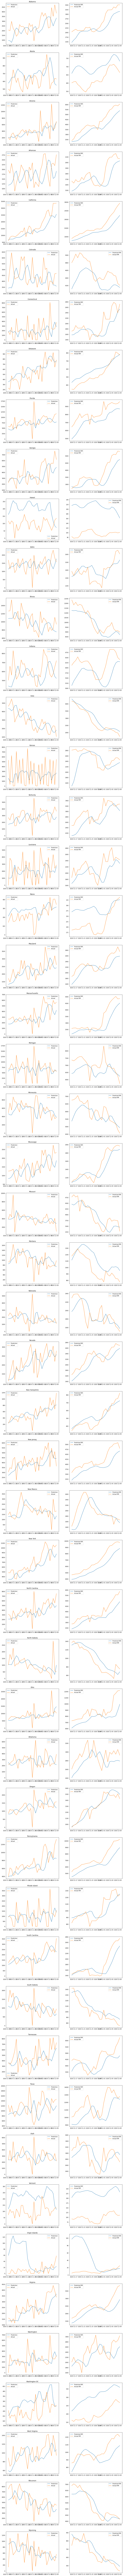

In [28]:
lin_model = LinearRegression()
run(oxford_data, 3, False, lin_model, 13, transform=False)

# SVR

In [ ]:
svr_params = {
    'C': 1,
    'gamma': 0.0001,
    'kernel': 'linear',
}

# svr_params = {
# }
svr_model = SVR(**svr_params)
# run(oxford_data, 3, False, svr_model, 13, True)

# GBR

In [ ]:
gb_param = {
#     'n_estimators': 700,
#     'max_depth': 16,
#     'min_samples_split': 100,
#     'learning_rate': 0.01,
#     'loss': 'ls'
}
gb_model = GradientBoostingRegressor(**gb_param)

# XGBoost

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBRegressor